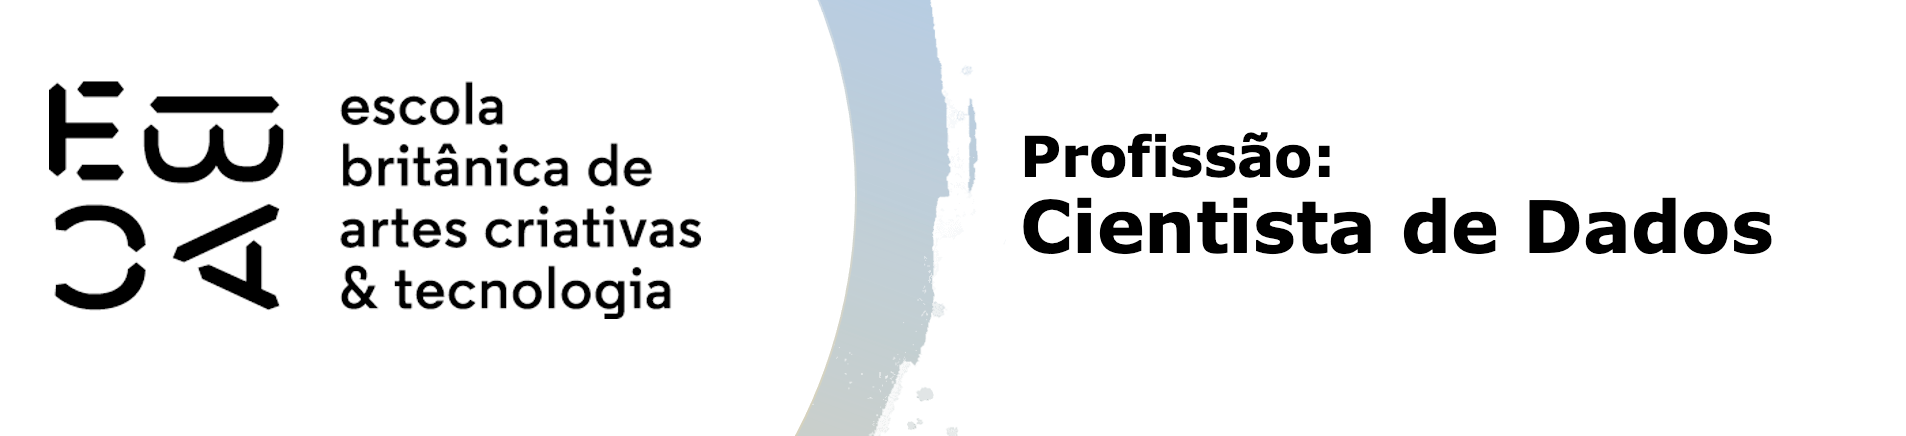

# Regressão III - Tarefa

Para iniciar as análises, vamos importar os pacotes que serão utilizados:

In [438]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

from scipy.interpolate import interp1d
from sklearn.metrics import r2_score

A seguir, temos uma função intitulada de **esp_vs_obs** que cria um gráfico dos *dados observados versus valores ajustados (preditos)* por um modelo de regressão OLS e inclui bandas de confiança tanto para as predições quanto para a média ajustada:

In [440]:
def esp_vs_obs(data, x_col, y_col, model):
   
    pred_ols = model.get_prediction()
    summary_frame = pred_ols.summary_frame()

    # Bandas de confiança
    iv_l = summary_frame["obs_ci_lower"]
    iv_u = summary_frame["obs_ci_upper"]
    m_l = summary_frame["mean_ci_lower"]
    m_u = summary_frame["mean_ci_upper"]

    # Configuração do gráfico
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(data[x_col], data[y_col], "o", label="Dados observados", alpha=0.7)
    ax.plot(data[x_col], model.fittedvalues, "r--.", label="Estimativa OLS")
    ax.plot(data[x_col], iv_u, "r--", label="Banda de confiança para y")
    ax.plot(data[x_col], iv_l, "r--")
    ax.plot(data[x_col], m_u, "g:", label="Banda de confiança para a média")
    ax.plot(data[x_col], m_l, "g:")
    ax.legend(loc="best")

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    plt.title("Valores Observados vs Ajustados (OLS)")
    plt.show()

### Carregamento e Tratamento dos Dados:

In [442]:
#carregando dados:
df = pd.read_csv('previsao_de_renda_II.csv')
#exibindo dados:
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


Agora vamos verificar os tipos dos nossos dados para ver se estão no formato correto:

In [444]:
df.dtypes

data_ref                  object
index                      int64
sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
dtype: object

A princípio, vamos alterar apenas o formato da variável *data_ref para datetime*.

In [446]:
df['data_ref']=pd.to_datetime(df['data_ref'])
df.dtypes

data_ref                 datetime64[ns]
index                             int64
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
dtype: object

Feito isso, vamos verificar se há dados faltantes no nosso df:

In [448]:
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

Temos um número expressivo de dados faltantes para tempo de emprego. Uma possível causa é que pode se tratar de pessoas desempregadas e por isso não consta, mas para efeito desse exercício, que tem como objetivo linearizar relações não lineares, iremos apenas substituir esses valores faltantes pela média. 

Mas primeiro, vejamos qual é o nosso número de observações para cada variável:

In [450]:
df.count()

data_ref                 750000
index                    750000
sexo                     750000
posse_de_veiculo         750000
posse_de_imovel          750000
qtd_filhos               750000
tipo_renda               750000
educacao                 750000
estado_civil             750000
tipo_residencia          750000
idade                    750000
tempo_emprego            624240
qt_pessoas_residencia    750000
renda                    750000
dtype: int64

Temos um número muito grande de observações, vejamos quanto por cento, representam os dados faltantes da variável tempo_emprego:

In [452]:
125760/750000 * 100

16.768

Temos então que 16,7% dos valores tempo_emprego não estão preenchidos, esses serão, como informado anteriormente, substituídos pela média.

In [454]:
#calculando a média de tempo_emprego:
media_tempo_emprego= df['tempo_emprego'].mean()
#preenchendo os faltantes com a média calculada:
df['tempo_emprego']= df['tempo_emprego'].fillna(media_tempo_emprego)
#contagem dos faltantes por variável:
df.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

Como exibido acima, não há mais valores faltantes no nosso df, logo, conseguimos realizar o preenchimento dos valores faltantes com a média.

O nosso próximo passo de preparo dos dados é **separar os últimos três meses de observações do nosso df para serem nossa base de teste, o restante será nossa base de treino.**

In [456]:
df['data_ref'].describe()

count                 750000
mean     2015-08-01 06:24:00
min      2015-01-01 00:00:00
25%      2015-04-01 00:00:00
50%      2015-08-01 00:00:00
75%      2015-12-01 00:00:00
max      2016-03-01 00:00:00
Name: data_ref, dtype: object

In [457]:
#converte as datas em períodos mensais, retorna os períodos unicos em data crescente e seleciona os três ultimos
df['data_ref'].dt.to_period('M').unique()[-3:]

<PeriodArray>
['2016-01', '2016-02', '2016-03']
Length: 3, dtype: period[M]

Vimos acima que a nossa base vai de janeiro de 2015 à março de 2016 e que os últimos três meses são também os 3 primeiros meses do ano de 2016, esses serão os meses para teste.

A seguir, vamos tornar a data o nosso índice e deixá-lo em ordem cronológica:

In [459]:
#ordenando e colocando a data como índice
df = df.sort_values('data_ref').set_index('data_ref')
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,13463,F,S,N,0,Assalariado,Superior completo,União,Casa,26,2.347945,2.0,1684.88
2015-01-01,5595,F,N,N,0,Assalariado,Médio,Casado,Casa,40,2.871233,2.0,2480.96
2015-01-01,4363,F,S,N,0,Servidor público,Superior completo,Solteiro,Casa,33,10.430137,1.0,2709.54
2015-01-01,14525,F,N,S,0,Servidor público,Superior completo,Casado,Casa,25,6.301370,2.0,12333.16


Feita a organização, vamos separar os últimos três meses para teste:

In [461]:
# Separando os conjuntos de treinamento e teste
df_treino = df[:'2015-12-01'] #até dezembro de 2015
df_teste = df['2016-01-01':] #a partir de janeiro de 2016
df_teste.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2016-01-01,5766,F,S,N,0,Pensionista,Superior completo,Solteiro,Casa,63,7.746165,1.0,1364.05
2016-01-01,567,F,N,S,0,Pensionista,Médio,Casado,Casa,59,7.746165,2.0,4856.40
2016-01-01,16493,F,N,S,0,Pensionista,Médio,Viúvo,Casa,54,7.746165,1.0,9885.74
2016-01-01,12464,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,32,2.446575,2.0,5489.06
2016-01-01,11973,M,N,S,0,Assalariado,Superior completo,Solteiro,Casa,43,3.843836,1.0,3421.59


Agora, antes de iniciar as nossas análises, vamos realizar mais um ajuste no nosso dataframe de treino, que é **criar a coluna log de renda**, faremos esse procedimento pois ele torna a distribuição dessa variável mais próxima do normal, permitindo a criação de modelos mais estáveis e precisos. 

In [463]:
#adicionando a coluna log de renda aos dfs:
df_treino['log_renda']= np.log(df_treino['renda'])
df_treino.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda
data_ref,,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,9.318131
2015-01-01,13463,F,S,N,0,Assalariado,Superior completo,União,Casa,26,2.347945,2.0,1684.88,7.429450
2015-01-01,5595,F,N,N,0,Assalariado,Médio,Casado,Casa,40,2.871233,2.0,2480.96,7.816401
2015-01-01,4363,F,S,N,0,Servidor público,Superior completo,Solteiro,Casa,33,10.430137,1.0,2709.54,7.904534
2015-01-01,14525,F,N,S,0,Servidor público,Superior completo,Casado,Casa,25,6.301370,2.0,12333.16,9.420047


Encerramos o nosso tratamento de dados e divisão de bases e vamos iniciar a criação do primeiro modelo. 

### Primeiro modelo

Vamos criar um primeiro modelo de regressão utilizando todas as variáveis do nosso conjunto de dados.

*Obs: a variável alvo é log_renda.*

In [466]:
#Primeiro Modelo: Regressão Linear com todas as variáveis
X1 = patsy.dmatrices('''np.log(renda) ~ C(sexo) 
                    + C(posse_de_veiculo) 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + C(tipo_renda) 
                    + C(educacao, Treatment(2)) 
                    + C(estado_civil) 
                    + C(tipo_residencia, Treatment(1)) 
                    + idade
                    + tempo_emprego
                    + qt_pessoas_residencia 
                    + 1''', df_treino)

res = smf.ols(X1, data=df_treino).fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=0.05)
print(f'R-quadrado: {res.rsquared:.2%}')
print(f'R-quadrado-ajustado: {res.rsquared_adj:.2%}')

# Resumo do modelo
resumo = res.summary()
tabela = pd.read_html(resumo.tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(left=.05, axis=1, props='color:red', subset='P>|t|')\
    .set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

R-quadrado: 42.37%
R-quadrado-ajustado: 42.37%


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,"8,3731","0,0060","1501,8150","0,0000","8,3620","8,3840"
C(sexo)[T.M],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(posse_de_veiculo)[T.S],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(posse_de_imovel)[T.S],"0,1786","0,0030","69,4970","0,0000","0,1740","0,1840"
C(tipo_renda)[T.Bolsista],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Empresário],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Pensionista],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Servidor público],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
"C(educacao, Treatment(2))[T.Fundamental]","0,0000","0,0000",nan,nan,"0,0000","0,0000"
"C(educacao, Treatment(2))[T.Médio]","0,0000","0,0000",nan,nan,"0,0000","0,0000"


De acordo com o modelo acima, as variáveis que possuem forte correlação com o log de renda são: 

- Posse de imóvel;
- Quantidade de filhos;
- Idade;
- Tempo de emprego;

A seguir, vamos criar um novo df apenas com essas variáveis explicativas e log_renda:

In [468]:
df_treino_b = df_treino[['log_renda', 'posse_de_imovel', 'qtd_filhos', 'idade', 'tempo_emprego']]

Agora, vamos criar um modelo com as variáveis do novo df e observar o $R^2$-ajustado:

In [470]:
#Segundo Modelo: Variáveis mais significativas
X1 = patsy.dmatrices('''log_renda ~ C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego 
                    + 1''', df_treino_b)

res_1 = smf.ols(X1, data=df_treino_b).fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=0.05)
print(f'R-quadrado: {res_1.rsquared:.2%}')
print(f'R-quadrado-ajustado: {res_1.rsquared_adj:.2%}')

R-quadrado: 42.37%
R-quadrado-ajustado: 42.37%


Feito o segundo modelo, vamos criar agora o terceiro. 

Esse receberá apenas a variável **tempo_emprego**, *uma vez que apresenta a estatística t mais alta, que mostra que é estatisticamente significativa no modelo e p_value igual a 0 que mostra que tem um efeito significativo na variável dependente renda.*

In [472]:
#Terceiro Modelo: Regressão Linear 
X1 = patsy.dmatrices('''log_renda ~ tempo_emprego 
                    + 1''', df_treino_b)

res_2 = smf.ols(X1, data=df_treino_b).fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=0.05)
print(f'R-quadrado: {res_2.rsquared:.2%}')
print(f'R-quadrado-ajustado: {res_2.rsquared_adj:.2%}')


R-quadrado: 41.74%
R-quadrado-ajustado: 41.74%


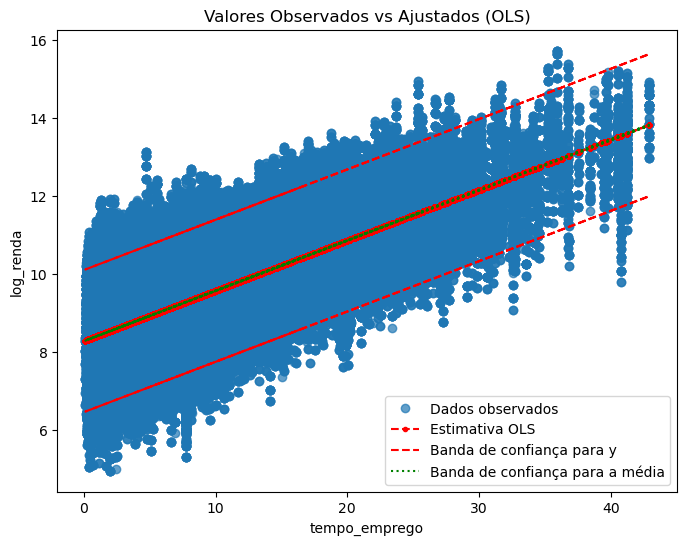

In [473]:
esp_vs_obs(data= df_treino_b, x_col= 'tempo_emprego', y_col='log_renda', model= res_2)

Observando o gráfico acima, é possível perceber que há uma correlação entre as variáveis, pois na medida que x aumenta, em tese y também aumenta. 

Entretanto, são diversas amostras e para realizar uma observação um pouco mais simplificada e fácil de compreender, poderiamos **fazer um resumo desses dados através da criação de categorias e obtenção da média para cada categoria.** 

Chamamos esse *'resumo'* de análise de perfil.

### Análise de perfil

Categorizaremos a variável ```tempo_emprego``` em 20 quantis  e faremos uma tabela de perfil (armazenada como dataframe) para esta categorização:

- Cada linha será uma categoria
- Haverá um coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Na sequencia, faremos um gráfico da média do tempo de emprego pela média do log-renda.

**Iniciando então nossa análise de perfil**, vamos fazer a segmentação da variável *tempo_emprego*:

In [477]:
# Segmentação de tempo_emprego em 20 categorias:
df_treino_b['tempo_emprego_cat'], quebras = pd.qcut(df_treino_b['tempo_emprego'], q=20, duplicates='drop', retbins=True)

# Tabela de Perfil
tab_perfil = df_treino_b.groupby('tempo_emprego_cat').agg(
    qtd_obs=('tempo_emprego_cat', 'size'),
    log_renda_med=('log_renda', 'mean'),
    tempo_emprego_med=('tempo_emprego', 'mean')
).reset_index().sort_values(by='tempo_emprego_cat')

tab_perfil.head()

,tempo_emprego_cat,qtd_obs,log_renda_med,tempo_emprego_med
0,"(0.11699999999999999, 0.816]",30234,8.364965,0.515042
1,"(0.816, 1.458]",30031,8.454323,1.125014
2,"(1.458, 2.096]",29736,8.569544,1.781261
3,"(2.096, 2.912]",30013,8.624148,2.510920
4,"(2.912, 3.636]",30408,8.755365,3.301180


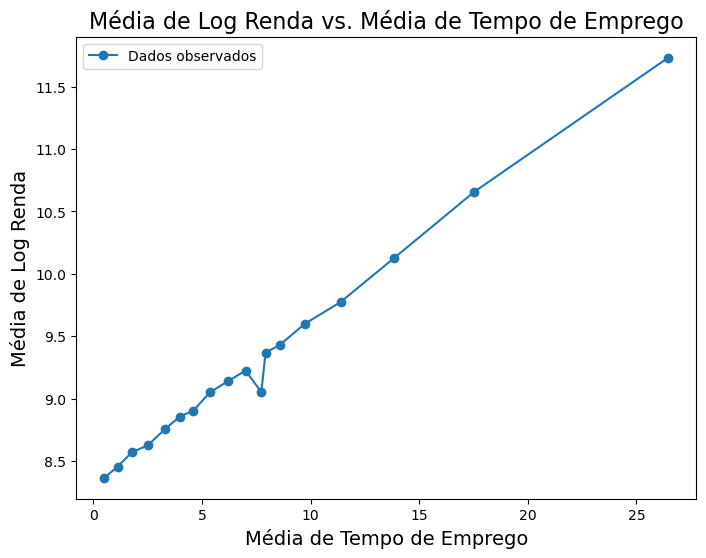

In [478]:
# Criando o gráfico 
fig, ax = plt.subplots(figsize=(8, 6))

# Plotando a linha para a Média_Log_Renda
ax.plot(tab_perfil['tempo_emprego_med'], tab_perfil['log_renda_med'], marker="o", label="Dados observados", alpha=1)


# Adicionando título e rótulos aos eixos
ax.set_title('Média de Log Renda vs. Média de Tempo de Emprego', fontsize=16)
ax.set_xlabel('Média de Tempo de Emprego', fontsize=14)
ax.set_ylabel('Média de Log Renda', fontsize=14)
ax.legend()
plt.show()

Observando o gráfico acima, podemos ver que conforme o tempo médio de emprego cresce, também há um aumento na renda, mostrando que realmente, a correlação entre elas é muito alta, como já citado anteriormente. 

Aqui temos uma relação que é contínua mas não linear, por isso, mais adiante, tentaremos linearizar essa relação. A seguir, utilizaremos novamente a função utilizada anteriormente, que traz a estimativa e a banda de confiança, além da construção do nosso Quarto Modelo, que traz a categorização dos dados:

R-quadrado-ajustado: 99.30%


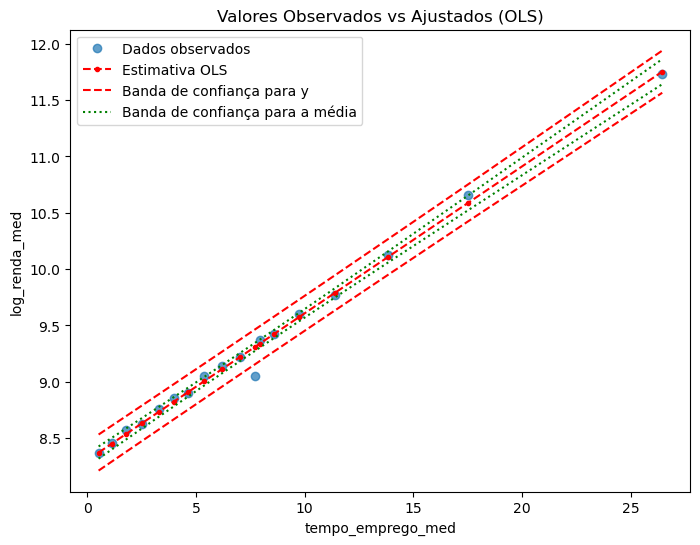

In [480]:
#Quarto Modelo: Categorização dos Dados
res_3= smf.ols('log_renda_med ~ tempo_emprego_med', data=tab_perfil).fit() 
print(f'R-quadrado-ajustado: {res_3.rsquared_adj:.2%}')

esp_vs_obs(data= tab_perfil, x_col= 'tempo_emprego_med', y_col='log_renda_med', model= res_3 )

Com esse 'resumo' dos dados, obtivemos um *$R^2$ - ajustado* alto, mas que reflete apenas os pontos agregados e não todos os pontos de fato.

A partir de agora, iremos utilizar todos os dados e testar estratégias de linearização.

### Tentativas de Linearização:

#### Transformações em X:
A seguir, treinaremos alguns modelos com diferentes transformações em x e vamos exibir o $R^2 - ajustado$ de cada um deles para decidirmos qual o melhor. 

In [484]:
res4 = smf.ols('log_renda ~ tempo_emprego', data=df_treino_b).fit() 
res5 = smf.ols('log_renda ~ tempo_emprego**2', data=df_treino_b).fit()
res6 = smf.ols('log_renda ~ np.sqrt(tempo_emprego)', data=df_treino_b).fit()
res7 = smf.ols('log_renda ~ np.log(tempo_emprego)', data=df_treino_b).fit()

print(f'R-quadrado ajustado com log de renda x tempo de emprego: {res4.rsquared_adj:.2%}')
print(f'R-quadrado ajustado com log de renda x tempo de emprego ao quadrado: {res5.rsquared_adj:.2%}')
print(f'R-quadrado ajustado com log de renda x raiz de tempo de emprego: {res6.rsquared_adj:.2%}')
print(f'R-quadrado ajustado com log de renda x log de tempo de emprego: {res7.rsquared_adj:.2%}')

R-quadrado ajustado com log de renda x tempo de emprego: 41.74%
R-quadrado ajustado com log de renda x tempo de emprego ao quadrado: 41.74%
R-quadrado ajustado com log de renda x raiz de tempo de emprego: 38.11%
R-quadrado ajustado com log de renda x log de tempo de emprego: 28.10%


De acordo com as métricas acima, os dois modelos que apresentaram maior *$R^2$ - ajustados* são os primeiros, ambos apresentaram o mesmo resultado, mas o diferencial é que o primeiro apenas tem transformação em y e será assim que iremos manter, a maneira mais simples possível. 

Lembrando que esse modelo já foi construído e é o **segundo modelo**. 

#### Suavização LOWESS:

Vamos utilizar o df_treino_b que é o criado com as variáveis mais significativas. 

*Iremos ajustar a suavização para a variável tempo_emprego e posteriormente, utilizar essa suavizada na construção do modelo juntamente com as demais:*

In [487]:
#Quinto modelo: Com Suavização LOWESS
lowess = sm.nonparametric.lowess(df_treino_b['log_renda'], df_treino_b['tempo_emprego'], frac=2/3)
f = interp1d(lowess[:, 0], lowess[:, 1], bounds_error=False)

df_treino_b['tempo_emprego_lowess'] = f(df_treino_b['tempo_emprego'])

X2 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego_lowess 
                    + 1''', df_treino_b)

res_8 = smf.ols(X2, data=df_treino_b).fit()
print(f'R² ajustado (LOWESS): {res_8.rsquared_adj:.2%}')

R² ajustado (LOWESS): 42.60%


R-quadrado ajustado com log de renda x tempo de emprego Suavizado: 42.60%


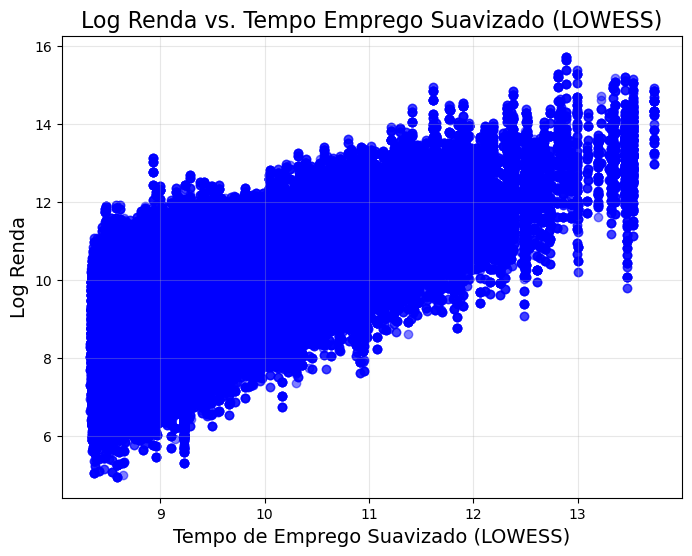

In [488]:
# Criando o gráfico de dispersão
fig, ax = plt.subplots(figsize=(8, 6))

# Plotando o gráfico de dispersão
ax.scatter(df_treino_b['tempo_emprego_lowess'], df_treino_b['log_renda'], color='b', alpha=0.5)

# Adicionando título e rótulos aos eixos
ax.set_title('Log Renda vs. Tempo Emprego Suavizado (LOWESS)', fontsize=16)
ax.set_xlabel('Tempo de Emprego Suavizado (LOWESS)', fontsize=14)
ax.set_ylabel('Log Renda', fontsize=14)

print(f'R-quadrado ajustado com log de renda x tempo de emprego Suavizado: {res_8.rsquared_adj:.2%}')

# Exibindo o gráfico
plt.grid(True, alpha=0.3)
plt.show()

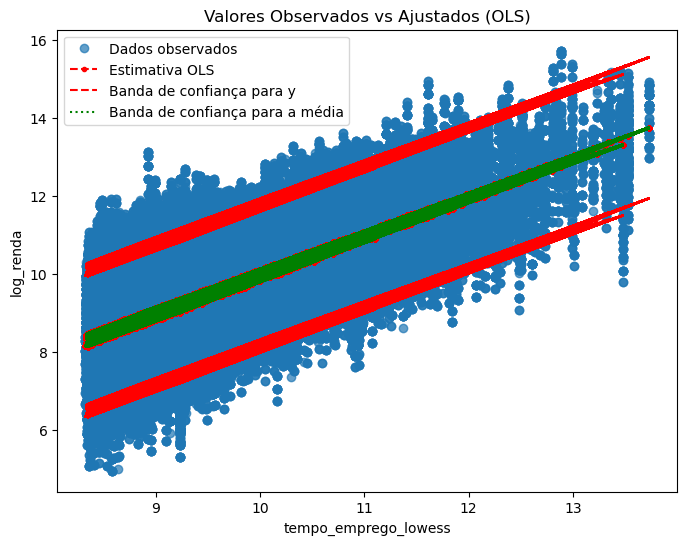

In [489]:
esp_vs_obs(data= df_treino_b, x_col= 'tempo_emprego_lowess', y_col='log_renda', model= res_8 )

Ao suavizar os dados de tempo_emprego com a função Lowess, conseguimos aumentar um pouco nosso $R^2$ - ajustado, que antes, com tempo de emprego e log renda era 41,7% agora com tempo de emprego suavizado e log renda ficou 42,6%.

### Avaliando o modelo

Iremos avaliar os modelos construídos na base de testes, são eles e seus respectivos $R^2$- ajustados:
| Modelo   | Variáveis Independentes                                            | Variável Dependente | R²-ajustado (%)  |
|----------|------------------------------------------------------|---------------------|---------|
| *Modelo 1* | Todas                    | log_renda           | 42,37   |
| *Modelo 2* | 'posse_de_imovel', 'qtd_filhos', 'idade', 'tempo_emprego' | log_renda           | 42,37   |
| *Modelo 3* | 'tempo_emprego'                | log_renda           | 41,74   |
| *Modelo 4* | 20 categorias de 'tempo_emprego'      | log_renda_med           | 99,30   |
| *Modelo 5* | 'posse_de_imovel', 'qtd_filhos', 'idade' + 'tempo_emprego' suavizado pela LOWESS | log_renda           | 42,60   |



Para testar os modelos citados acima, precisamos organizar os dados de teste da mesma forma que foram organizados os de treino. Para isso:

- Criaremos o df_teste_b, com as mesmas variáveis do df_treino_b;
- Criaremos o log de renda;
- Realizaremos a criação das categorias para a variável tempo_emprego.
- Suavização Lowess para tempo de emprego.

In [492]:
# 1º passo) criação de df_teste_b com as mesmas variáveis de df_treino_b:
df_teste_b = df_teste[['renda', 'posse_de_imovel', 'qtd_filhos', 'idade', 'tempo_emprego']]

#2º passo) Criação do log de renda dentro do df_treino_b:
df_teste_b['log_renda']= np.log(df_teste_b['renda'])
df_teste_b.head()

,renda,posse_de_imovel,qtd_filhos,idade,tempo_emprego,log_renda
data_ref,,,,,,
2016-01-01,1364.05,N,0,63,7.746165,7.218213
2016-01-01,4856.40,S,0,59,7.746165,8.488053
2016-01-01,9885.74,S,0,54,7.746165,9.198849
2016-01-01,5489.06,N,0,32,2.446575,8.610512
2016-01-01,3421.59,S,0,43,3.843836,8.137861


In [493]:
#3º passo) Criação das categorias para tempo de emprego:
df_teste_b['tempo_emprego_cat'], quebras = pd.qcut(df_teste_b['tempo_emprego'], q=20, duplicates='drop', retbins=True)

# Tabela de Perfil
tab_perfil_teste = df_teste_b.groupby('tempo_emprego_cat').agg(
    qtd_obs=('tempo_emprego_cat', 'size'),
    log_renda_med=('log_renda', 'mean'),
    tempo_emprego_med=('tempo_emprego', 'mean')
).reset_index().sort_values(by='tempo_emprego_cat')

tab_perfil_teste.head()

,tempo_emprego_cat,qtd_obs,log_renda_med,tempo_emprego_med
0,"(0.11699999999999999, 0.827]",7601,7.202604,0.520903
1,"(0.827, 1.468]",7464,7.257080,1.134215
2,"(1.468, 2.099]",7459,7.401755,1.790156
3,"(2.099, 2.912]",7511,7.472002,2.514075
4,"(2.912, 3.636]",7507,7.578685,3.299975


In [495]:
#4º passo: Definição da suavização dos dados na variável lowess

lowess = sm.nonparametric.lowess(df_teste_b.log_renda, df_teste_b.tempo_emprego, frac=2/3)

# Extrai os valores de tempo_emprego (x) e log_renda suavizado (y)
lowess_x = lowess[:, 0]  # Valores de tempo_emprego
lowess_y = lowess[:, 1]  # Valores suavizados de log_renda

# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_teste_b['tempo_emprego_lowess'] = f(df_teste_b.tempo_emprego)
df_teste_b.head(2)

,renda,posse_de_imovel,qtd_filhos,idade,tempo_emprego,log_renda,tempo_emprego_cat,tempo_emprego_lowess
data_ref,,,,,,,,
2016-01-01,1364.05,N,0,63,7.746165,7.218213,"(7.474, 7.746]",8.041415
2016-01-01,4856.40,S,0,59,7.746165,8.488053,"(7.474, 7.746]",8.041415


Agora que realizamos todas as etapas preparatórias, vamos iniciar a avaliação dos modelos.

#### Avaliando o MODELO 1 (log de renda ~ todas as variáveis):

In [505]:
# Previsão Modelo 1 com todas
df_teste['log_renda']=np.log(df_teste['renda'])
df_teste['pred_1'] = res.predict(df_teste)
r = df_teste[['pred_1', 'log_renda']].corr().iloc[0, 1]
print(f'R² Teste (Modelo 1): {r**2:.2%}')

R² Teste (Modelo 1): 52.95%


#### Avaliando o MODELO 2 (log de renda ~ apenas as variáveis mais significativas):

In [508]:
# Previsão Modelo 2 com as mais importantes
df_teste_b['pred_2'] = res_1.predict(df_teste_b)
r = df_teste_b[['pred_2', 'log_renda']].corr().iloc[0, 1]
print(f'R² Teste (Modelo 2): {r**2:.2%}')

R² Teste (Modelo 2): 52.95%


#### Avaliando o MODELO 3 (log de renda ~ tempo_emprego):

In [511]:
# Previsão Modelo 3 com tempo_emprego
df_teste_b['pred_3'] = res_2.predict(df_teste_b)
r = df_teste_b[['pred_3', 'log_renda']].corr().iloc[0, 1]
print(f'R² Teste (Modelo 3): {r**2:.2%}')

R² Teste (Modelo 3): 52.16%


#### Avaliando o MODELO 4 (média log de renda ~ categorias tempo_emprego):

In [514]:
# Previsão Modelo 4 com tempo_emprego
tab_perfil_teste['pred_4'] = res_3.predict(tab_perfil_teste)
r = tab_perfil_teste[['pred_4', 'log_renda_med']].corr().iloc[0, 1]
print(f'R² Teste (Modelo 4): {r**2:.2%}')

R² Teste (Modelo 4): 99.32%


#### Avaliando o MODELO 5 (log de renda ~ variáveis mais significativas e tempo_emprego suavizado):

In [519]:
# Previsão Modelo 5 - LOWES
df_teste_b['pred_5'] = res_8.predict(df_teste_b)
r = df_teste_b[['pred_5', 'log_renda']].corr().iloc[0, 1]
print(f'R² Teste (Modelo 5): {r**2:.2%}')

R² Teste (Modelo 5): 53.27%


#### Resultados e comparação dos modelos:

| Modelo       | R²-ajustado (%) - Treino | R²-ajustado (%) - Teste |
|--------------|--------------------------|--------------------------|
| *Modelo 1*   |        42,37             |         52,95                   |
| *Modelo 2*   |        42,37             |         52,95                   |
| *Modelo 3*   |        41,74             |         51,16                   |
| *Modelo 4*   |        99,30             |         99,32                   |
| *Modelo 5*   |        42,60             |         53,27                   |



Podemos observar na tabela acima, que todos os modelos apresentaram resultados melhores no teste. Dentre eles, há um modelo que se saiu bem até demais, o Modelo 4, entretanto, é preciso lembrar que esse modelo reflete os pontos agregados e não os dados de fato, portanto, **dizemos aqui que o modelo com melhor desempenho foi o número 5, que utiliza a suavização Lowess para a variável tempo_emprego.** 